# Energy Mix
**Group 4**  
Jianyi Chen, Jincheng Hong, Tianyu Su, Yicheng Huang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus

## 2. Simple model

In [2]:
sources = ["solar", "wind", "hydro", "coal", "natural_gas"]
lcoe_cost = {"solar": 86.5, "wind": 106.5, "hydro": 213.0, "coal": 74.0, "natural_gas": 54.0}
pollution_cost = {"solar": 37, "wind": 12, "hydro": 150, "coal": 1000, "natural_gas": 430}
fixed_cost = {"solar": 1516000, "wind": 1389000, "hydro": 6428500, "coal": 4074000, "natural_gas": 1300000}
production_limit = {"solar": 999, "wind": 999, "hydro": 43000.0*1000, "coal": 200*1000, "natural_gas": 500.632*1000}
renewable_indicator = {"solar": 1, "wind": 1, "hydro": 1, "coal": 0, "natural_gas": 0}
consumption_rate = {"solar": 0.90, "wind": 0.85, "hydro": 0.95, "coal": 0.70, "natural_gas": 0.80}

para1 = {
    "LCOE_Cost": [lcoe_cost[source] for source in sources],
    "Pollution_Cost": [pollution_cost[source] for source in sources],
    "Production_Limit": [production_limit[source] for source in sources],
    "Renewable_Indicator": [renewable_indicator[source] for source in sources],
    "Consumption_Rate": [consumption_rate[source] for source in sources]
}

parameters_long = pd.DataFrame(para1, index=sources)

para2 = {
    "source": sources,
    "c": [lcoe_cost[source] for source in sources],
    "p": [pollution_cost[source] for source in sources],
    "l": [production_limit[source] for source in sources],
    "r": [renewable_indicator[source] for source in sources],
}

parameters = pd.DataFrame(para2)

In [3]:
parameters_long

,LCOE_Cost,Pollution_Cost,Production_Limit,Renewable_Indicator,Consumption_Rate
solar,86.5,37,999.0,1,0.90
wind,106.5,12,999.0,1,0.85
hydro,213.0,150,43000000.0,1,0.95
coal,74.0,1000,200000.0,0,0.70
natural_gas,54.0,430,500632.0,0,0.80


In [4]:
parameters

,source,c,p,l,r
0,solar,86.5,37,999.0,1
1,wind,106.5,12,999.0,1
2,hydro,213.0,150,43000000.0,1
3,coal,74.0,1000,200000.0,0
4,natural_gas,54.0,430,500632.0,0


In [5]:
B = 12 * 10**9
D = 25263.2 * 1000
lam = 0.5

sources = parameters['source'].tolist()
c = parameters.set_index('source')['c'].to_dict()
p = parameters.set_index('source')['p'].to_dict()
l = parameters.set_index('source')['l'].to_dict()
r = parameters.set_index('source')['r'].to_dict()

prob = LpProblem("EnergyMix1", LpMinimize)

# Decision variables
x = {s: LpVariable(f"x_{s}", lowBound=0, upBound=l[s], cat='Continuous') for s in sources}

# Objective function
prob += lpSum(p[s] * x[s] for s in sources)

# Constraint1
prob += lpSum(x[s] for s in sources) >= D

# Constraint2
prob += lpSum(c[s] * x[s] for s in sources) <= B

# Constraint3
renewable_numerator = lpSum(x[s] * r[s] for s in sources)
renewable_denominator = lpSum(x[s] for s in sources)
prob += renewable_numerator >= lam * renewable_denominator

# Constraint4
for s in sources:
    prob += x[s] <= l[s]
    prob += x[s] >= 0

prob.solve()

print("Status:", LpStatus[prob.status])
result = parameters.copy()
result["x"] = [x[s].varValue for s in sources]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/17ccc50e3beb431d91ed43402f8483e6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/17ccc50e3beb431d91ed43402f8483e6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 18 COLUMNS
At line 49 RHS
At line 63 BOUNDS
At line 69 ENDATA
Problem MODEL has 13 rows, 5 columns and 25 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-12) rows, 5 (0) columns and 5 (-20) elements
0  Obj 3.6840854e+09 Primal inf 702630.54 (1)
1  Obj 3.7892293e+09
Optimal - objective value 3.7892293e+09
After Postsolve, objective 3.7892293e+09, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 3789229251 - 1 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (W

In [6]:
result

,source,c,p,l,r,x
0,solar,86.5,37,999.0,1,999.0
1,wind,106.5,12,999.0,1,999.0
2,hydro,213.0,150,43000000.0,1,25261202.0
3,coal,74.0,1000,200000.0,0,0.0
4,natural_gas,54.0,430,500632.0,0,0.0


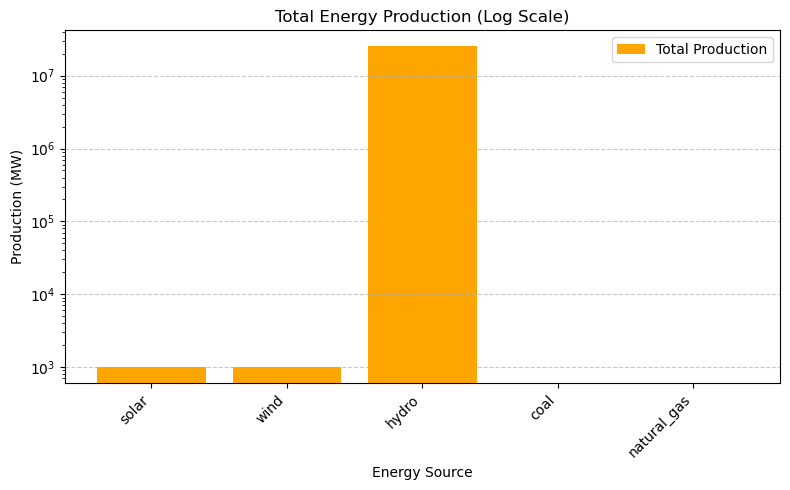

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(result["source"], result["x"], color="orange", label="Total Production")


ax.set_xlabel("Energy Source")
ax.set_ylabel("Production (MW)")
ax.set_title("Total Energy Production (Log Scale)")

ax.set_yscale("log")

ax.set_xticks(range(len(result["source"])))
ax.set_xticklabels(result["source"], rotation=45, ha="right")

ax.grid(axis="y", linestyle="--", alpha=0.7)

ax.legend()

plt.tight_layout()
plt.savefig("model1_vis.png", dpi=300, bbox_inches="tight")

plt.show()

## 3. Simple model

In [8]:
parameters

,source,c,p,l,r
0,solar,86.5,37,999.0,1
1,wind,106.5,12,999.0,1
2,hydro,213.0,150,43000000.0,1
3,coal,74.0,1000,200000.0,0
4,natural_gas,54.0,430,500632.0,0


In [9]:
D = 25263.2 * 1000
E_max = 3.8 * 10**9
lam = 0.5

sources = parameters['source'].tolist()
c = parameters.set_index('source')['c'].to_dict()
p = parameters.set_index('source')['p'].to_dict()
l = parameters.set_index('source')['l'].to_dict()
r = parameters.set_index('source')['r'].to_dict()

prob = LpProblem("EnergyMix2", LpMinimize)

# Decision variables
x = {s: LpVariable(f"x_{s}", lowBound=0, upBound=l[s], cat='Continuous') for s in sources}

# Objective function
prob += lpSum(c[s] * x[s] for s in sources)

# Constraint1
prob += lpSum(x[s] for s in sources) >= D

# Constraint2
prob += lpSum(p[s] * x[s] for s in sources) <= E_max

# Constraint3
renewable_numerator = lpSum(x[s] * r[s] for s in sources)
renewable_denominator = lpSum(x[s] for s in sources)
prob += renewable_numerator >= lam * renewable_denominator

# Constraint4
for s in sources:
    prob += x[s] <= l[s]
    prob += x[s] >= 0

prob.solve()

print("Status:", LpStatus[prob.status])

result = parameters.copy()
result["x"] = [x[s].varValue for s in sources]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/34168bd7ef914558a73a4f126652df54-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/34168bd7ef914558a73a4f126652df54-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 18 COLUMNS
At line 49 RHS
At line 63 BOUNDS
At line 69 ENDATA
Problem MODEL has 13 rows, 5 columns and 25 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-11) rows, 5 (0) columns and 10 (-15) elements
0  Obj 5.365087e+09 Primal inf 74998.215 (1)
2  Obj 5.3747126e+09
Optimal - objective value 5.3747126e+09
After Postsolve, objective 5.3747126e+09, infeasibilities - dual 0 (0), primal 8.5367432e-07 (1)
Presolved model was optimal, full model needs cleaning up
Optimal - objective value 5.3747126e+09
Optimal objective 5374712586 - 2 iterations time 0.002,

In [10]:
result

,source,c,p,l,r,x
0,solar,86.5,37,999.0,1,9.990000e+02
1,wind,106.5,12,999.0,1,9.990000e+02
2,hydro,213.0,150,43000000.0,1,2.522274e+07
3,coal,74.0,1000,200000.0,0,0.000000e+00
4,natural_gas,54.0,430,500632.0,0,3.846696e+04


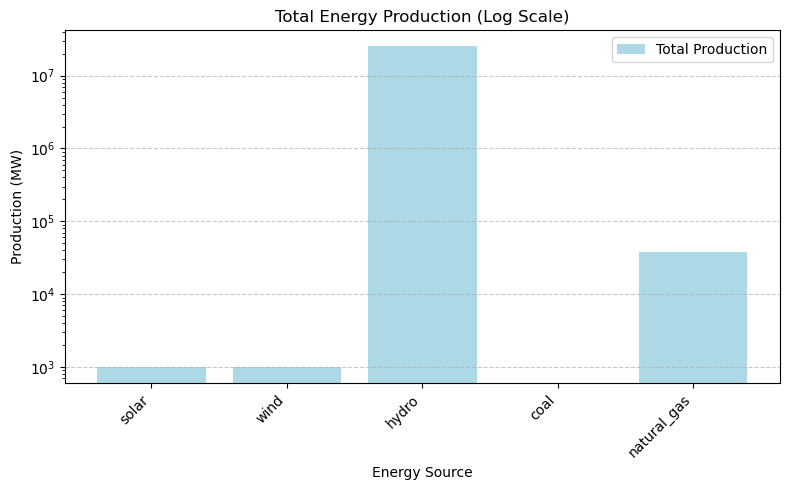

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(result["source"], result["x"], color="lightblue", label="Total Production")


ax.set_xlabel("Energy Source")
ax.set_ylabel("Production (MW)")
ax.set_title("Total Energy Production (Log Scale)")

ax.set_yscale("log")

ax.set_xticks(range(len(result["source"])))
ax.set_xticklabels(result["source"], rotation=45, ha="right")

ax.grid(axis="y", linestyle="--", alpha=0.7)

ax.legend()

plt.tight_layout()
plt.savefig("model2_vis.png", dpi=300, bbox_inches="tight")

plt.show()

## 4. Optimizing both cost and environmental impact

In [12]:
parameters

,source,c,p,l,r
0,solar,86.5,37,999.0,1
1,wind,106.5,12,999.0,1
2,hydro,213.0,150,43000000.0,1
3,coal,74.0,1000,200000.0,0
4,natural_gas,54.0,430,500632.0,0


In [13]:
D = 10000
lam = 0.5
alpha, beta = 0.7, 0.3

sources = parameters['source'].tolist()
c = parameters.set_index('source')['c'].to_dict()
p = parameters.set_index('source')['p'].to_dict()
l = parameters.set_index('source')['l'].to_dict()
r = parameters.set_index('source')['r'].to_dict()

prob = LpProblem("EnergyMix3", LpMinimize)

# Decision variables
x = {s: LpVariable(f"x_{s}", lowBound=0, upBound=l[s], cat='Continuous') for s in sources}

# Objective function
prob += alpha*lpSum(c[s] * x[s] for s in sources) + beta*lpSum(p[s] * x[s] for s in sources)

# Constraint1
prob += lpSum(x[s] for s in sources) >= D

# # Constraint2
# prob += lpSum(c[s] * x[s] for s in sources) <= B

# # Constraint2
# prob += lpSum(p[s] * x[s] for s in sources) <= E_max

# Constraint3
renewable_numerator = lpSum(x[s] * r[s] for s in sources)
renewable_denominator = lpSum(x[s] for s in sources)
prob += renewable_numerator >= lam * renewable_denominator

# Constraint4
for s in sources:
    prob += x[s] <= l[s]
    prob += x[s] >= 0

prob.solve()

print("Status:", LpStatus[prob.status])

result = parameters.copy()
result["x"] = [x[s].varValue for s in sources]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/21d188d2f6774431953c887c6eb81c8f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/21d188d2f6774431953c887c6eb81c8f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 17 COLUMNS
At line 43 RHS
At line 56 BOUNDS
At line 62 ENDATA
Problem MODEL has 12 rows, 5 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-10) rows, 5 (0) columns and 10 (-10) elements
0  Obj 0 Primal inf 10000 (1)
2  Obj 1566338.4
Optimal - objective value 1566338.4
After Postsolve, objective 1566338.4, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1566338.4 - 2 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.0

In [14]:
result

,source,c,p,l,r,x
0,solar,86.5,37,999.0,1,999.0
1,wind,106.5,12,999.0,1,999.0
2,hydro,213.0,150,43000000.0,1,3002.0
3,coal,74.0,1000,200000.0,0,0.0
4,natural_gas,54.0,430,500632.0,0,5000.0


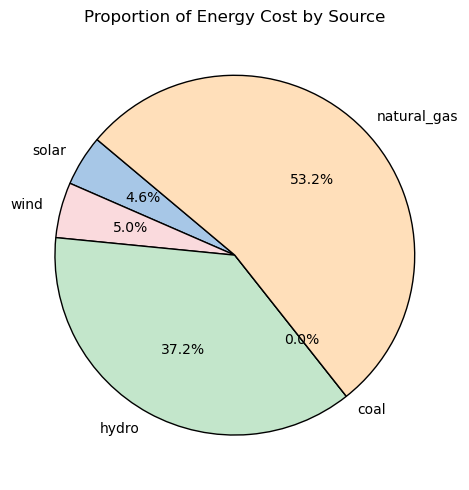

In [15]:
total_cost = sum((alpha* (result["c"]) * (result["x"]) + beta * (result["p"] * result["x"])))

proportions = (alpha* (result["c"]) * (result["x"]) + beta * (result["p"] * result["x"])) / total_cost
fig, ax = plt.subplots(figsize=(8, 5))

ax.pie(
    proportions, 
    labels=result["source"], 
    autopct="%1.1f%%", 
    startangle=140, 
    colors = ["#A7C7E7",
          "#FADADD",  
          "#C3E6CB",  
          "#FFD1A4",  
          "#FFDFBA"]  ,  
    wedgeprops={"edgecolor": "black", "linewidth": 1}  )


ax.set_title("Proportion of Energy Cost by Source")
plt.tight_layout()
plt.savefig("model3_vis.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. Optimization involving time dependent energy sources

In [16]:
sources = ["solar", "wind", "hydro", "coal", "natural_gas"]

para = pd.DataFrame({
    "c": [86.5, 106.5, 213.0, 74.0, 54.0],
    "p": [37, 12, 150, 1000, 430],
}, index=sources)

l = pd.DataFrame({
    "l0": [452.632, 452.632, 21500.0, 1000000000.0, 226.316],
    "l1": [0.0, 600.0, 21500.0, 1000000000.0, 226.316]
}, index=sources)

Dt = np.array([1200,800])

para

,c,p
solar,86.5,37
wind,106.5,12
hydro,213.0,150
coal,74.0,1000
natural_gas,54.0,430


In [17]:
l

,l0,l1
solar,4.526320e+02,0.000000e+00
wind,4.526320e+02,6.000000e+02
hydro,2.150000e+04,2.150000e+04
coal,1.000000e+09,1.000000e+09
natural_gas,2.263160e+02,2.263160e+02


In [18]:
Dt

array([1200,  800])

In [19]:
alpha, beta = 0.7, 0.3

prob = LpProblem("EnergyMix4", LpMinimize)

# Decision variables
x = {(i, t): LpVariable(f"x_{i}_{t}", lowBound=0, upBound=l.loc[i, f"l{t}"], cat='Continuous') 
     for i in sources for t in [0, 1]}

# Objective function
cost_term = lpSum(para.loc[i, "c"] * x[i, t] for i in sources for t in [0, 1])
pollution_term = lpSum(para.loc[i, "p"] * x[i, t] for i in sources for t in [0, 1])
prob += alpha * cost_term + beta * pollution_term

# Constraint1
for t in [0, 1]:
    prob += lpSum(x[i, t] for i in sources) >= Dt[t]

# Constraint2
for i in sources:
    for t in [0, 1]:
        prob += x[i, t] <= l.loc[i, f"l{t}"]
        prob += x[i, t] >= 0

prob.solve()
print("Status:", LpStatus[prob.status])

x_result = pd.DataFrame({
    "source": sources,
    "x0": [x[i, 0].varValue for i in sources],
    "x1": [x[i, 1].varValue for i in sources]
})

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/43049c91bc274bab84e9ccd25d9b415e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/43049c91bc274bab84e9ccd25d9b415e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27 COLUMNS
At line 68 RHS
At line 91 BOUNDS
At line 102 ENDATA
Problem MODEL has 22 rows, 10 columns and 30 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-20) rows, 9 (-1) columns and 9 (-21) elements
0  Obj 0 Primal inf 2000 (2)
2  Obj 199084.1
Optimal - objective value 199084.1
After Postsolve, objective 199084.1, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 199084.1044 - 2 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.0

In [20]:
x_result

,source,x0,x1
0,solar,452.632,0.0
1,wind,452.632,600.0
2,hydro,68.420,0.0
3,coal,0.000,0.0
4,natural_gas,226.316,200.0


In [21]:
vis = x_result.copy().set_index("source")
vis["l0"] = l["l0"]
vis["l1"] = l["l1"]
vis.reset_index(inplace=True) 

vis

,source,x0,x1,l0,l1
0,solar,452.632,0.0,4.526320e+02,0.000000e+00
1,wind,452.632,600.0,4.526320e+02,6.000000e+02
2,hydro,68.420,0.0,2.150000e+04,2.150000e+04
3,coal,0.000,0.0,1.000000e+09,1.000000e+09
4,natural_gas,226.316,200.0,2.263160e+02,2.263160e+02


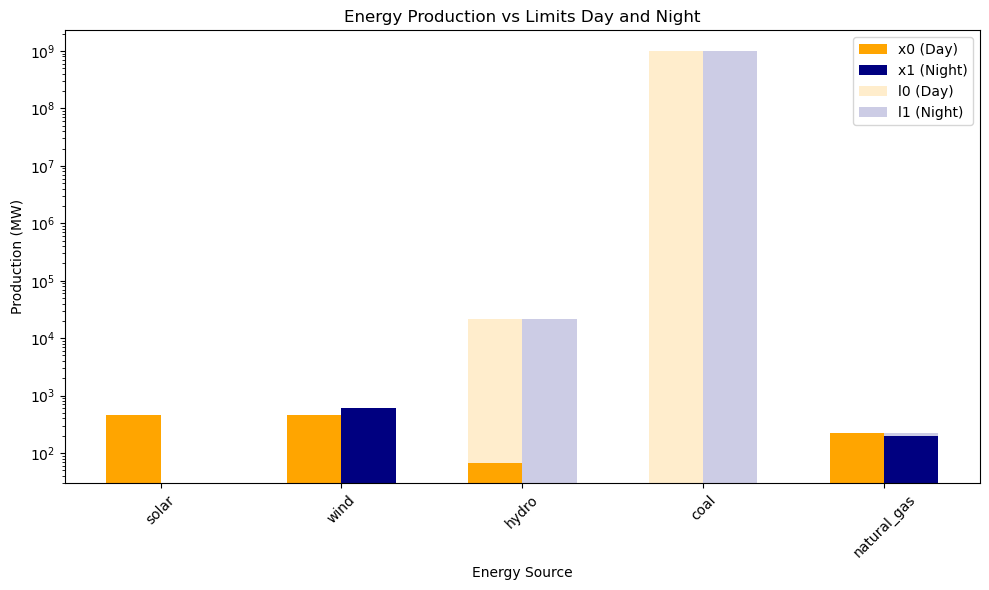

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
indices = np.arange(len(vis))

ax.bar(indices - bar_width/2, vis["x0"], bar_width, label="x0 (Day)", color="orange")
ax.bar(indices + bar_width/2, vis["x1"], bar_width, label="x1 (Night)", color="navy")

ax.bar(indices - bar_width/2, vis["l0"], bar_width, color='orange', label="l0 (Day)", alpha = 0.2)
ax.bar(indices + bar_width/2, vis["l1"], bar_width, color='navy', label="l1 (Night)",  alpha = 0.2)

ax.set_xlabel("Energy Source")
ax.set_ylabel("Production (MW)")
ax.set_title("Energy Production vs Limits Day and Night")
ax.set_xticks(indices)
ax.set_xticklabels(vis["source"], rotation=45)
ax.set_yscale("log")
ax.legend()

plt.tight_layout()
plt.savefig("model4_vis.png", dpi=300)

plt.show()

## 6. Optimization involving time dependent energy sources

In [23]:
sources = ["solar", "wind", "hydro", "coal", "natural_gas"]

para = pd.DataFrame({
    "c": [86.5, 106.5, 213.0, 74.0, 54.0],
    "p": [37, 12, 150, 1000, 430],
}, index=sources)

l = pd.DataFrame({
    "l0": [452.632, 452.632, 21500.0, 1000000000.0, 226.316],
    "l1": [0.0, 600.0, 21500.0, 1000000000.0, 226.316]
}, index=sources)

Dt = np.array([1200,800])

para

,c,p
solar,86.5,37
wind,106.5,12
hydro,213.0,150
coal,74.0,1000
natural_gas,54.0,430


In [24]:
l

,l0,l1
solar,4.526320e+02,0.000000e+00
wind,4.526320e+02,6.000000e+02
hydro,2.150000e+04,2.150000e+04
coal,1.000000e+09,1.000000e+09
natural_gas,2.263160e+02,2.263160e+02


In [25]:
Dt

array([1200,  800])

In [26]:
S_max = 1000

alpha, beta = 0.3, 0.6

prob = LpProblem("EnergyMix5", LpMinimize)

# Decision variables
x = {(i, t): LpVariable(f"x_{i}_{t}", lowBound=0, upBound=l.loc[i, f"l{t}"], cat='Continuous') 
     for i in sources for t in [0, 1]}

s = {t: LpVariable(f"s_{t}", lowBound=0, upBound=S_max, cat='Continuous') for t in [0, 1]}

# Objective function
cost_term = lpSum(para.loc[i, "c"] * x[i, t] for i in sources for t in [0, 1])
pollution_term = lpSum(para.loc[i, "p"] * x[i, t] for i in sources for t in [0, 1])
prob += alpha * cost_term + beta * pollution_term

# Constraints
for t in [0, 1]:
    # Demand
    prob += lpSum(x[i, t] for i in sources) + (s[t - 1] if t > 0 else 0) >= Dt[t]
    # Battery capacity
    prob += s[t] <= S_max
    prob += s[t] >= 0

# Battery dynamics
prob += s[0] == s[1] + lpSum(x[(i,0)] for i in sources) - Dt[0]
prob += s[1] == s[0] + lpSum(x[(i,1)] for i in sources) - Dt[1]

# production limits
for i in sources:
    for t in [0, 1]:
        prob += x[i, t] <= l.loc[i, f"l{t}"]
        prob += x[i, t] >= 0

prob.solve()

x_result = pd.DataFrame({
    "source": sources,
    "x0": [x[i, 0].varValue for i in sources],
    "x1": [x[i, 1].varValue for i in sources]
})

s_result = pd.DataFrame({
    "time": [0, 1],
    "storage": [s[t].varValue for t in [0, 1]]
})

print("Status:", LpStatus[prob.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/04ac6a3888e740c5a4c03bf769b373b9-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/04ac6a3888e740c5a4c03bf769b373b9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 33 COLUMNS
At line 93 RHS
At line 122 BOUNDS
At line 135 ENDATA
Problem MODEL has 28 rows, 12 columns and 49 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (-25) rows, 4 (-8) columns and 9 (-40) elements
0  Obj 84874.644 Primal inf 1600 (2) Dual inf 153.9 (1)
2  Obj 139144.64
Optimal - objective value 139144.64
After Postsolve, objective 139144.64, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 139144.644 - 2 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   

In [27]:
x_result

,source,x0,x1
0,solar,452.632,0.0
1,wind,452.632,600.0
2,hydro,494.736,0.0
3,coal,0.000,0.0
4,natural_gas,0.000,0.0


In [28]:
s_result

,time,storage
0,0,1000.0
1,1,800.0


In [29]:
vis = x_result.copy().set_index("source")
vis["l0"] = l["l0"]
vis["l1"] = l["l1"]
vis.reset_index(inplace=True) 
new_row = pd.DataFrame({"source": ["battery"], "x0": s_result.iloc[0,1], "x1": s_result.iloc[1,1], "l0": S_max, "l1": S_max})
vis = pd.concat([vis, new_row], ignore_index=True)

print(vis)

        source        x0     x1            l0            l1
0        solar   452.632    0.0  4.526320e+02  0.000000e+00
1         wind   452.632  600.0  4.526320e+02  6.000000e+02
2        hydro   494.736    0.0  2.150000e+04  2.150000e+04
3         coal     0.000    0.0  1.000000e+09  1.000000e+09
4  natural_gas     0.000    0.0  2.263160e+02  2.263160e+02
5      battery  1000.000  800.0  1.000000e+03  1.000000e+03


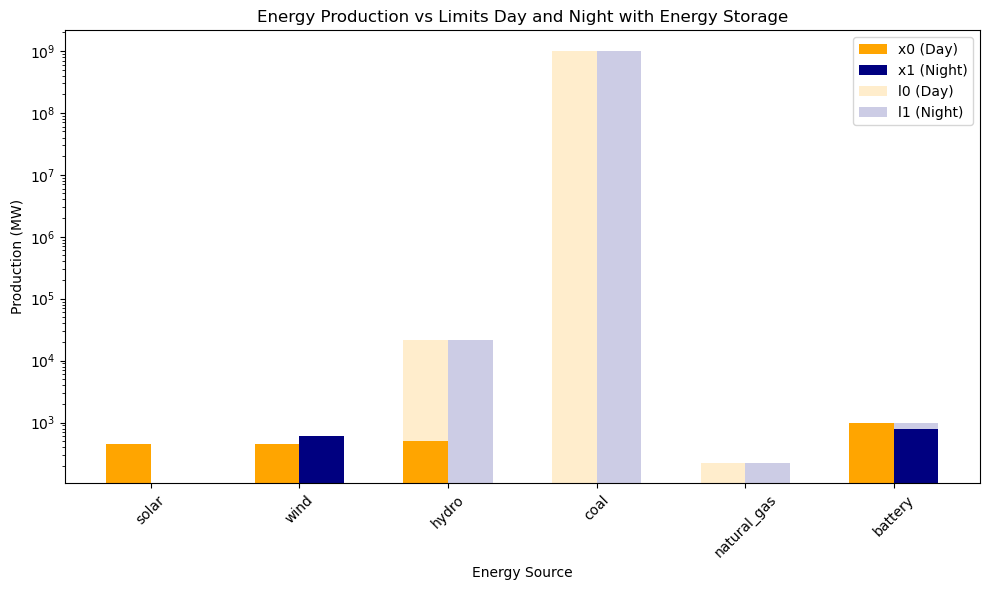

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
indices = np.arange(len(vis))

ax.bar(indices - bar_width/2, vis["x0"], bar_width, label="x0 (Day)", color="orange")
ax.bar(indices + bar_width/2, vis["x1"], bar_width, label="x1 (Night)", color="navy")

ax.bar(indices - bar_width/2, vis["l0"], bar_width, color='orange', label="l0 (Day)", alpha = 0.2)
ax.bar(indices + bar_width/2, vis["l1"], bar_width, color='navy', label="l1 (Night)",  alpha = 0.2)

ax.set_xlabel("Energy Source")
ax.set_ylabel("Production (MW)")
ax.set_title("Energy Production vs Limits Day and Night with Energy Storage")
ax.set_xticks(indices)
ax.set_xticklabels(vis["source"], rotation=45)
ax.set_yscale("log")
ax.legend()

plt.tight_layout()
plt.savefig("model5_vis.png", dpi=300)

plt.show()